# Starbucks Capstone Challenge

## Challenge Description


### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Project Overview

The dataset for this project is a simplified version of the real Starbucks rewards mobile app.
This project seeks to use transaction, demographic and offer data to analyze how different customers respond to different offers and thus, build a recommendation engine that recommends Starbucks which offer should be sent to a particular customer.


## Problem Statement
An offer could be buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a required amount that the user is expected to spend. Offers can be delivered via multiple channels.

We are interested in answering: 
1. How do different factors such as demographics affect response to offers?
2. What factors based on the data available, have the most impact on offer completion?
3. What steps can we take with the answers from No 2, to increase offer completion rates?

Strategy
- Clean, process and combine the data from offer portfolio, customer profile, and transaction. Each row of this combined dataset will describe the customer demographic data, offer's attributes, and whether the offer was successful. The possibility of someone completing an offer without even viewing it should be taken into account and taken care of. Transactions should only be considered when the person viewed and completed the offer.
- Build a model to predict the offer success based on the provided customer demographics and the offer attributes. Compare Logistic regression, Random forest classifier and KNeighbors classifier.
- Obtain the important feature columns that influence the success of an offer and leverage data visualization to answer the questions that were framed above.

## Metrics
The success of the project would be determined by the accuracy and F1-score of the model built.The model will be built with the parameters of the model that has the highest accuracy and F1-score. The model should have accuracy and F1-scores of above 75% so we ensure it performs well on new data sets.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [159]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

### Portofolio Data

In [45]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [74]:
## check data size and missing values

print ("Portfolio Data Size (Zero-based indexing) : " + str(portfolio.shape))

print ("Portfolio Missing Values : ")
print (portfolio.isnull().sum())

Portfolio Data Size (Zero-based indexing) : (10, 6)
Portfolio Missing Values : 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


In [75]:
#check portfolio data type
print (portfolio.dtypes)

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object


#### Remarks: We can see the the porfolio dataset has no missing values and the columns are of different data types.

###  Profile Data

In [48]:
## Check data size and missing values

print ("Profile Data Size (Zero-based indexing) : " + str(profile.shape))

print ("Profile Missing Values : ")
print (profile.isnull().sum())

Profile Data Size (Zero-based indexing) : (17000, 5)
Profile Missing Values : 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [59]:
no_gender = profile['gender'].isnull().sum()
print("There is {} rows without gender, which represents {}% of the data".format(no_gender, no_gender/profile.shape[0]*100))

There is 2175 rows without gender, which represents 12.794117647058822% of the data


In [60]:
no_income = profile['gender'].isnull().sum()
print("There is {} rows without gender, which represents {}% of the data".format(no_income, no_income/profile.shape[0]*100))

There is 2175 rows without gender, which represents 12.794117647058822% of the data


In [49]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [50]:
profile.describe(include = ['O'])

,gender,id
count,14825,17000
unique,3,17000
top,M,206ce5f33eb14623888263d2b945d089
freq,8484,1


In [68]:
males_percent = profile['gender'].value_counts()
print("There  {} males, which represents {}% of the data".format(males_percent['M'], males_percent['M']/profile.shape[0]*100))

There  8484 males without gender, which represents 49.90588235294118% of the data


In [69]:
females_percent = profile['gender'].value_counts()
print("There  {} females, which represents {}% of the data".format(females_percent['F'], females_percent['F']/profile.shape[0]*100))

There  6129 females, which represents 36.05294117647059% of the data


In [51]:
def plot_hist(data, title, xlabel, ylabel, bins=20):
    """Plot a histogram with values passed as input."""
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [54]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    plot_hist(data=profile['age'], title='Customer Age Distrbution', xlabel='Age', ylabel='Count', bins=20)

    # Display Histogram of Customer Income
    plot_hist(data=profile['income'], title='Customer Income Distrbution', xlabel='Income', ylabel='Count', bins=20)
    sns.countplot(profile['gender'])
    

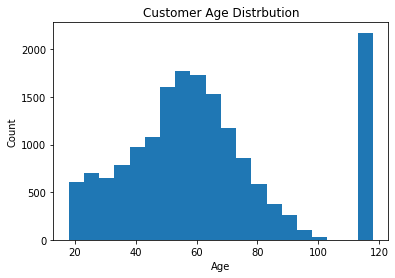

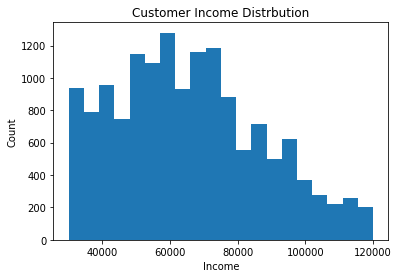

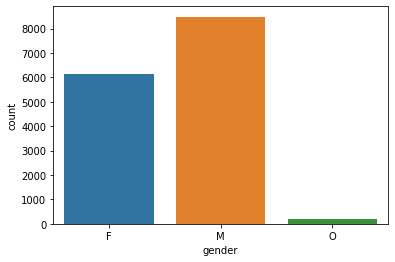

In [55]:
display_customer_profile()

From the age distribution, most customers are in the range of 40 to 70 years old with a lot of missing data which is recoreded as 118 years old in the dataset.

Also, most customers have income between 49k and 80k with 12% of values missig. Let's calculate the percentage of outliers

In [70]:
# Percent of income outliers
above_75 = profile[profile['income']>80000].count().sum()/profile.shape[0]
below_25 = profile[profile['income']<49000].count().sum()/profile.shape[0]
print('Percent of customers with outlier income= {}%'.format(above_75+below_25))

Percent of customers with outlier income= 2.114411764705882%


In [57]:
profile[['gender','age']].groupby(['gender'], as_index = False).mean().sort_values(by='age',ascending=False)

,gender,age
0,F,57.544950
2,O,54.400943
1,M,52.116690


In [58]:
profile[['gender','income']].groupby(['gender'], as_index = False).mean().sort_values(by='income',ascending=False)

,gender,income
0,F,71306.412139
2,O,63287.735849
1,M,61194.601603


#### Remarks: 

The ranking for both mean age and income is Females, Other, Males. So females tend to earn the most and are older

We can see the the profile dataset has same number of missing values in both income and gender. It could be that people that did not enter their gender did not also enter their income. 

The income distribution is left skewed and Male gender makes up over 50% of the customers. The 'Other' gender is quite negligible and could be dropped.  

### Transcript Data

In [78]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [76]:
## check data size and missing values

print ("Transcript Data Size (Zero-based indexing) : " + str(transcript.shape))

print ("Transcript Missing Values : ")
print (transcript.isnull().sum())

Transcript Data Size (Zero-based indexing) : (306534, 4)
Transcript Missing Values : 
person    0
event     0
value     0
time      0
dtype: int64


In [77]:
print(transcript.dtypes)

person    object
event     object
value     object
time       int64
dtype: object


In [79]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

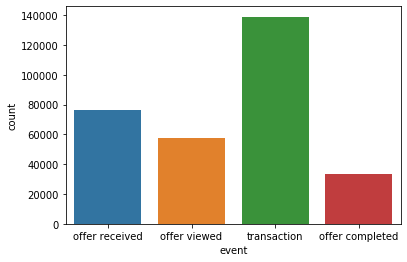

In [80]:
sns.countplot(transcript['event'])

* There are no missing values in the transcript data. 
* There are 4 event types in transcript: offer received, offer viewed, transaction, offer completed.

## Data preparation

### Portfolio Dataset   
* One-hot encoding for channels and offer type then append to dataset.
* Drop original columns after encoding.
* Rename columns.

In [145]:
def clean_portfolio(portfolio):
        
    '''
    Data cleaning of the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    '''
    
    # one-hot encoding for channels column
    channels = ['web', 'email', 'mobile', 'social']

    for channel in channels:
        portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1
        
    # one-hot encoding offer_type
    dummies = pd.get_dummies(portfolio['offer_type'], prefix='event_type', prefix_sep='_')

    # Append to the original dataframe
    portfolio = pd.concat([portfolio, dummies], axis=1)
    
    # Drop original columns
    portfolio.drop(['channels', 'offer_type'],axis=1 ,inplace=True)
    
    # rename column names
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
    portfolio.rename(columns={'duration': 'offer_duration_days'}, inplace=True)
    portfolio.rename(columns={'difficulty': 'offer_difficulty'}, inplace=True)
    portfolio.rename(columns={'reward': 'offer_reward'}, inplace=True)
    for col in ["email", "mobile", "social", "web"]:
        portfolio.rename(columns={col: ("channel_" + col)}, inplace=True)

    
    return portfolio

In [148]:
cleaned_portfolio = clean_portfolio(portfolio.copy())
cleaned_portfolio.head()

,offer_reward,offer_difficulty,offer_duration_days,offer_id,channel_web,channel_email,channel_mobile,channel_social,event_type_bogo,event_type_discount,event_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


### Profile Data   
* One-hot encoding for channels and offer type.
* Convert data types
* Drop null values (118 is used to represent null for age)
* Drop original columns after encoding.
* Rename columns.

In [81]:
def clean_profile(profile):
    
    '''
    Data cleaning of the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    '''

    # Convert became_member_on date from int to date time type
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    profile['year'] = profile['became_member_on'].dt.year
    profile['quarter'] = profile['became_member_on'].dt.quarter
   
    
    # Drop null values(age =118) 
    profile.drop(profile[profile.age==118].index, inplace=True)
    
    # One-hot encoding for gender
    gender_dummies = pd.get_dummies(profile.gender, prefix='gender', prefix_sep='_')
    profile = pd.concat([profile, gender_dummies], axis=1)
    
    # One-hot encoding for date
    year_dummy = pd.get_dummies(profile.year, prefix='year', prefix_sep='_')
    quarter_dummy = pd.get_dummies(profile.quarter, prefix='quarter', prefix_sep='_')
    profile = pd.concat([profile, year_dummy, quarter_dummy], axis=1)
    
    # Drop original columns
    profile.drop(['gender', 'became_member_on', 'year', 'quarter'], axis=1, inplace=True)
    
    # rename column name into meaningful name
    profile.rename(columns={'id': 'customer_id'}, inplace=True)

    
    return profile

In [82]:
cleaned_profile = clean_profile(profile.copy())

Confirm data has been cleaned

In [86]:
cleaned_profile['income'].isnull().sum()

0

In [88]:
cleaned_profile.head(10)

,age,customer_id,income,gender_F,gender_M,gender_O,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,quarter_1,quarter_2,quarter_3,quarter_4
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,1,0,0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,1,0,1,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,1,1,0,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,1,0,0,0,0,1
13,61,aa4862eba776480b8bb9c68455b8c2e1,57000.0,1,0,0,0,0,0,0,1,0,0,0,1,0
14,26,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,0,1,0,0,1,0,0,0,0,1,0,0,0
15,62,31dda685af34476cad5bc968bdb01c53,71000.0,1,0,0,0,0,0,1,0,0,1,0,0,0
16,49,62cf5e10845442329191fc246e7bcea3,52000.0,0,1,0,0,1,0,0,0,0,0,0,0,1
18,57,6445de3b47274c759400cd68131d91b4,42000.0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [89]:
cleaned_profile.shape

(14825, 16)

[Text(0.5, 1.0, 'income in general')]

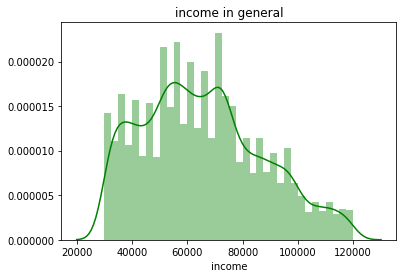

In [94]:
sns.distplot(cleaned_profile["income"] , color="green").set(title = 'income in general')

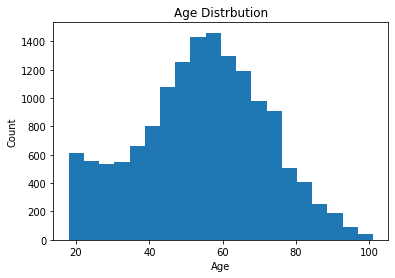

In [92]:
plot_hist(data=cleaned_profile['age'], title='Age Distrbution', xlabel='Age', ylabel='Count')

### Transcript dataset
* No need to drop null values as there are no null values
* One-hot encode event column.
* Encode value column and split it to different columns.
* Merge offer id and offer_id columns by assigning values of offer id column to offer_id column.
* Assign zeros to null values in offer amounts and rewards
* Change time column from hours to days.
* Rename column names.
* Remove customer ids that are not available in profile dataset.
* Drop original columns that that have been encoded.

In [105]:
def clean_transcript(transcript):
    '''
    Data cleaning of the profile dataframe
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    transcript - the cleaned transcript dataframe
    '''
    # One-hot encode events 
    dummies = pd.get_dummies(transcript.event)
    transcript = pd.concat([transcript, dummies], axis=1)
    
    # Encode value column and split it to differet columns
    value_df = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)
    transcript = pd.concat([transcript, value_df], axis=1)
    
    # Assign values of offer id column to offer_id column to remove duplicate columns
    transcript['offer_id'] = transcript['offer_id'].fillna(transcript['offer id'])
    
    # offer amount and reward with null values will be assigned as zeros
    transcript['amount'] = transcript['amount'].replace(np.nan, 0)
    transcript['reward'] = transcript['reward'].replace(np.nan, 0)
    
    # Change time column from hours to days
    transcript['time'] = transcript['time']/24.0
    
    # Change column name into a meaningful name
    transcript.rename(columns= {"time": "time_days"}, inplace = True)
    transcript.rename(columns= {'amount': 'money_spent'}, inplace=True)
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    transcript.rename(columns={'reward': 'reward_gained'}, inplace=True)
    transcript.rename(columns={'transaction': 'transaction_done'}, inplace=True)
    
    # Drop customers ids that not available at transcript dataset, because we know nothing about them.
    transcript = transcript[transcript['customer_id'].isin(cleaned_profile['customer_id'])]

    # Drop original columns 
    transcript.drop(['event', 'value', 'offer id'], axis=1, inplace=True)
        
    return transcript

In [106]:
cleaned_transcript = clean_transcript(transcript.copy())

In [109]:
## View cleaned transcript dataframe

cleaned_transcript.head()

,customer_id,time_days,offer completed,offer received,offer viewed,transaction_done,money_spent,offer_id,reward_gained
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
2,e2127556f4f64592b11af22de27a7932,0.0,0,1,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
5,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0,0,0.0,3f207df678b143eea3cee63160fa8bed,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0


In [110]:
## View cleaned profile dataframe

cleaned_profile.head()

,age,customer_id,income,gender_F,gender_M,gender_O,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,quarter_1,quarter_2,quarter_3,quarter_4
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,1,0,0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,1,0,1,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,1,1,0,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [113]:
# Let's view the events for a random customer
cleaned_transcript[cleaned_transcript.customer_id == '389bc3fa690240e798340f5a15918d5c']

## Notice that offer_id is null when a transaction is done.

,customer_id,time_days,offer completed,offer received,offer viewed,transaction_done,money_spent,offer_id,reward_gained
5,389bc3fa690240e798340f5a15918d5c,0.00,0,1,0,0,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0.0
12650,389bc3fa690240e798340f5a15918d5c,0.00,0,0,1,0,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0.0
32625,389bc3fa690240e798340f5a15918d5c,2.50,0,0,0,1,9.54,NaN,0.0
32626,389bc3fa690240e798340f5a15918d5c,2.50,1,0,0,0,0.00,f19421c1d4aa40978ebb69ca19b0e20d,5.0
53179,389bc3fa690240e798340f5a15918d5c,7.00,0,1,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
77212,389bc3fa690240e798340f5a15918d5c,8.00,0,0,1,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
110831,389bc3fa690240e798340f5a15918d5c,14.00,0,1,0,0,0.00,2906b810c7d4411798c6938adc9daaa5,0.0
132803,389bc3fa690240e798340f5a15918d5c,14.75,0,0,1,0,0.00,2906b810c7d4411798c6938adc9daaa5,0.0
150601,389bc3fa690240e798340f5a15918d5c,17.00,0,1,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
179953,389bc3fa690240e798340f5a15918d5c,18.25,0,0,1,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0


It appears that different interactions for a user is contained in different rows and columns. So the offer receipt, viewing, and completion could be on different rows. We need to have all of them together on one row to capture the customer actions properly.

To do this, we will:
* Get the list of customers id
* Get the information related to the customer as well as the list of of offer ids
* Drop duplicate and null ids
* For each offer the customer receives, get the customer information related with the offer.
* Next, get when the offer was completed by the customer and the offer info.
* Assign offer_successful to True if offer was received, viewed and completed.
* Append the values to the transcript dataframe

In [115]:
def build_transaction_df(cleaned_transcript):
    '''
    Receives transcript dataframe and applies steps to build a robust transaction dataframe that contains the receipt, view and completion of an offer for each customer.
    
    INPUT:
    transcript - the transcript dataframe to be used in building the transaction_df
    
    OUTPUT:
    transaction_df - the transaction dataframe
    '''

    # Create a list of customer IDs
    customer_ids_list = list(cleaned_transcript.customer_id.unique())

    # Create transaction dataframe with necessary columns
    transactions_df = pd.DataFrame(columns= ['customer_id', 'offer_id', 'time_days', 'offer_received', 'offer_viewed',
                                         'offer_completed', 'offer_successful', 'transaction_done', 'money_spent', 'reward_gained'])
    customer_df = pd.DataFrame()
    past_time = 0

    # Get customers in cleaned_transcript that are in list of customer id

    for customer_id in customer_ids_list:
        customer_df = cleaned_transcript[cleaned_transcript.customer_id == customer_id]
        offers_id_list = customer_df['offer_id']

        # Drop duplicate offer_id
        offers_id_list = offers_id_list.drop_duplicates()
        offers_id_list = [x for x in offers_id_list if pd.notnull(x)]

        for offer_id in offers_id_list:
            # Loop through to create entry for each offer received per customer 
            customer_df_1 = customer_df[(customer_df['customer_id'] == customer_id) & (customer_df['offer_id']== offer_id)]
            
            current_time_in_days = customer_df_1.loc[:,'time_days'].max()
            offer_completed = customer_df_1.loc[:,'offer completed'].max()
            offer_received = customer_df_1.loc[:,'offer received'].max()
            offer_viewed = customer_df_1.loc[:,'offer viewed'].max()
            reward_gained = customer_df_1.loc[:,'reward_gained'].sum()
        
            customer_transaction_df = customer_df[customer_df['customer_id'] == customer_id]
            current_time_transaction = customer_transaction_df[(customer_transaction_df['time_days']> past_time) & (customer_transaction_df['time_days']<= current_time_in_days)]
            money_spent = current_time_transaction.loc[:,'money_spent'].sum()
            if (money_spent):
                transaction_done=1
            else:
                transaction_done=0
      
            past_time = current_time_in_days
        
            if (offer_received and offer_viewed and offer_completed): 
                offer_successful = 1
            else:
                offer_successful = 0
            # To the transaction dataframe, add offer received, offer viewed, offer completed, offer successful and money for each user per offer
            if (current_time_in_days >= 0):
                transactions_df = transactions_df.append({'customer_id': customer_id, 'offer_id': offer_id, 'time_days': current_time_in_days,
                                                'offer_received': offer_received, 'offer_viewed': offer_viewed, 'offer_completed': offer_completed,
                                                'offer_successful': offer_successful,'transaction_done':transaction_done, 'money_spent':money_spent,
                                                'reward_gained': reward_gained}, ignore_index=True)
                
                
    return transactions_df
    

In [117]:
transactions_dataframe = build_transaction_df(cleaned_transcript)


NameError: name 'transactions_df' is not defined

In [160]:
transactions_dataframe.head()

,customer_id,offer_id,time_days,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.50,1,1,1,1,1,19.89,5.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,9.00,1,1,0,0,1,17.78,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,21.25,1,1,1,1,1,95.04,10.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,24.25,1,1,1,1,1,26.56,5.0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.75,1,1,0,0,0,0.00,0.0


In [136]:
transactions_dataframe[transactions_dataframe['customer_id']=='e2127556f4f64592b11af22de27a7932']

,customer_id,offer_id,time_days,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.75,1,1,0,0,0,0.00,0.0
5,e2127556f4f64592b11af22de27a7932,3f207df678b143eea3cee63160fa8bed,14.00,1,0,0,0,1,39.31,0.0
6,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.75,1,1,1,1,1,18.42,5.0
7,e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,21.75,1,1,1,1,0,0.00,2.0


In [ ]:
#### Let's merge the customer profile and porfolion to each transaction to have our combined dataframe

In [138]:
transaction_profile_df = transactions_dataframe.merge(cleaned_profile, on='customer_id')
transaction_profile_df.head()

,customer_id,offer_id,time_days,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,quarter_1,quarter_2,quarter_3,quarter_4
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.50,1,1,1,1,1,19.89,5.0,...,0,0,0,0,1,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,9.00,1,1,0,0,1,17.78,0.0,...,0,0,0,0,1,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,21.25,1,1,1,1,1,95.04,10.0,...,0,0,0,0,1,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,24.25,1,1,1,1,1,26.56,5.0,...,0,0,0,0,1,0,0,1,0,0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.75,1,1,0,0,0,0.00,0.0,...,0,0,0,0,0,1,0,1,0,0


In [139]:
#Find high outliers based on income

outlier_above = transaction_profile_df[(transaction_profile_df['income']>80000) & (transaction_profile_df['transaction_done'] == 1)].shape[0]/transaction_profile_df[transaction_profile_df['transaction_done'] == 1].shape[0]

In [140]:
#Find low outliers based on income

outlier_below = transaction_profile_df[(transaction_profile_df['income']<49000) & (transaction_profile_df['transaction_done'] == 1)].shape[0]/transaction_profile_df[transaction_profile_df['transaction_done'] == 1].shape[0]

In [141]:
#Find total outliers based on income
# We notice that transactions from outliers account for half of the transactions

print(outlier_above + outlier_below)

0.4834441847923782


In [149]:
# Finally, merge transaction_profile_df with cleaned_porfolio dataframe
merged_df = transaction_profile_df.merge(cleaned_portfolio, on='offer_id')
merged_df.head()

,customer_id,offer_id,time_days,offer_received,offer_viewed,offer_completed,offer_successful,transaction_done,money_spent,reward_gained,...,offer_reward,offer_difficulty,offer_duration_days,channel_web,channel_email,channel_mobile,channel_social,event_type_bogo,event_type_discount,event_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.50,1,1,1,1,1,19.89,5.0,...,5,5,7,1,1,1,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.75,1,1,1,1,1,18.42,5.0,...,5,5,7,1,1,1,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,20.75,1,1,1,1,0,0.00,5.0,...,5,5,7,1,1,1,0,1,0,0
3,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,25.25,1,1,0,0,0,0.00,0.0,...,5,5,7,1,1,1,0,1,0,0
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,29.75,1,1,0,0,0,0.00,0.0,...,5,5,7,1,1,1,0,1,0,0


## Train Model

#### Before training the model we need to drop some columns
1. We drop reward_gained since it is same as offer_reward
2. We drop offer_completed and transaction completed and leave offer_successful
3. We drop a column of one-hot encoded colums to avoid multicollinearity

In [150]:
merged_df.columns.tolist()

['customer_id',
 'offer_id',
 'time_days',
 'offer_received',
 'offer_viewed',
 'offer_completed',
 'offer_successful',
 'transaction_done',
 'money_spent',
 'reward_gained',
 'age',
 'income',
 'gender_F',
 'gender_M',
 'gender_O',
 'year_2013',
 'year_2014',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'quarter_1',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 'offer_reward',
 'offer_difficulty',
 'offer_duration_days',
 'channel_web',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'event_type_bogo',
 'event_type_discount',
 'event_type_informational']

In [174]:
drop_cols = [ 'time_days','offer_received', 'offer_viewed','offer_completed','transaction_done', 'gender_F', 'year_2013', 'quarter_1', 
              'event_type_bogo', 'reward_gained']
model_df = merged_df.drop(columns=drop_cols, axis=1)

In [155]:
model_df.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_successful,money_spent,age,income,gender_M,gender_O,...,quarter_4,offer_reward,offer_difficulty,offer_duration_days,channel_web,channel_email,channel_mobile,channel_social,event_type_discount,event_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,19.89,75,100000.0,0,0,...,0,5,5,7,1,1,1,0,0,0
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,18.42,68,70000.0,1,0,...,0,5,5,7,1,1,1,0,0,0
2,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0.00,65,53000.0,1,0,...,0,5,5,7,1,1,1,0,0,0
3,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0.00,56,88000.0,0,0,...,0,5,5,7,1,1,1,0,0,0
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0.00,59,41000.0,1,0,...,0,5,5,7,1,1,1,0,0,0


In [176]:
from sklearn.model_selection import train_test_split

X = model_df.drop(['offer_successful', 'customer_id', 'offer_id'], axis=1)
#model_df['offer_successful'] = model_df['offer_successful']
y = model_df['offer_successful']
y=pd.to_numeric(y)
# Split the model data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show split results
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
print(y.dtypes)

Training set has 44177 samples.
Testing set has 11045 samples.
int64


In [157]:
target_names=['Offer failed', 'Offer successful']

In [177]:
from sklearn.metrics import accuracy_score, f1_score

lg_reg = LogisticRegression(random_state=42)
lg_reg.fit(X_train, y_train)
lg_pred = lg_reg.predict(X_test)

print('LogisticRegression Model')
print(classification_report(y_test, lg_pred, target_names=target_names))

LogisticRegression Model
                  precision    recall  f1-score   support

    Offer failed       0.63      0.76      0.69      6328
Offer successful       0.55      0.40      0.46      4717

        accuracy                           0.60     11045
       macro avg       0.59      0.58      0.57     11045
    weighted avg       0.60      0.60      0.59     11045



In [178]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf.fit(X_train, y_train)
rf_pred = random_forest_clf.predict(X_test)

print('RandomForestClassifier Model Results')
print(classification_report(y_test, rf_pred, target_names=target_names))

RandomForestClassifier Model Results
                  precision    recall  f1-score   support

    Offer failed       0.82      0.80      0.81      6328
Offer successful       0.74      0.76      0.75      4717

        accuracy                           0.78     11045
       macro avg       0.78      0.78      0.78     11045
    weighted avg       0.79      0.78      0.79     11045



In [179]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = KNeighborsClassifier()
neighbors.fit(X_train, y_train)
neighbors_pred = neighbors.predict(X_test)

print('KNeighborsClassifier Model Results')
print(classification_report(y_test, neighbors_pred, target_names=target_names))

KNeighborsClassifier Model Results
                  precision    recall  f1-score   support

    Offer failed       0.75      0.72      0.73      6328
Offer successful       0.64      0.69      0.67      4717

        accuracy                           0.70     11045
       macro avg       0.70      0.70      0.70     11045
    weighted avg       0.71      0.70      0.71     11045



## Model Evaluation and Fine tuning

In the train model step, we built 3 models and got these results:
* Logistic regression: 
    1. Precision: 0.60
    2. Recall: 0.60
    3. F1 score: 0.59
* Random forest classifier:
     1. Precision: 0.79
     2. Recall: 0.78
     3. F1 score: 0.79
* KNeighbors classifier 
     1. Precision:  0.71
     2. Recall: 0.70
     3. F1 score: 0.71   
     
Based on the results, Random Forest Classifier is the best model to proceed with.

#### Tuning the best model:


In [181]:
# Get model parameters
print(random_forest_clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [182]:

n_estimators = [100, 200, 300]
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 100]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_forest_2 = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = random_forest_2, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.8min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [183]:
random_forest_final = RandomForestClassifier(n_estimators= 200,
 min_samples_split= 4,
 min_samples_leaf= 2,
 max_features = 'auto',
 max_depth = 50,
 bootstrap = True)

random_forest_final.fit(X_train, y_train)
random_forest_final_pred = random_forest_final.predict(X_test)

print('RandomForestClassifier Model')
print(classification_report(y_test, random_forest_final_pred, target_names=target_names))

RandomForestClassifier Model
                  precision    recall  f1-score   support

    Offer failed       0.83      0.82      0.82      6328
Offer successful       0.76      0.78      0.77      4717

        accuracy                           0.80     11045
       macro avg       0.80      0.80      0.80     11045
    weighted avg       0.80      0.80      0.80     11045



## Feature Importance 

In [185]:
def plot_feature(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Create the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#4caf50', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [ ]:
importances = rf.feature_importances_

# Plot
plot_feature(importances, X_train, y_train)